# Demonstration code for "Building a complete RL system" lecture",

## Introduction
This code demonstrates our implementation of SARSA for the [Taxi-v3](https://gymnasium.farama.org/environments/toy_text/taxi/) environment and serves as additional information to go alongside the "Building a complete Rl system" lecture.
The lecture is delivered as part of the [Reinforcement Learning (2024) course](http://www.drps.ed.ac.uk/23-24/dpt/cxinfr11010.htm) at the University of Edinburgh.



## Dependencies
To run the python code, you will need [Gymnasium](https://gymnasium.farama.org/) which can be installed using

    pip install gymnasium gymnasium[toy-text]

Further dependencies are [Matplotlib](https://matplotlib.org/) and [NumPy](https://numpy.org/) which can be installed with

	pip install matplotlib
	pip install numpy


## Let's get to know the Environment - Taxi-v3
| **t=0**                                           | **t=1**                                           | **t=2**                                           |
|:--------------------------------------------------|:--------------------------------------------------|:--------------------------------------------------|
| ![t0_illustration](./media/Taxi-v3/Taxi-v3_1.png) | ![t1_illustration](./media/Taxi-v3/Taxi-v3_2.png) | ![t2_illustration](./media/Taxi-v3/Taxi-v3_3.png) |


### Goal: Pickup passenger and drop it off at destination

### Observations: int $\in [0, 499]$ encoding
- Taxi location (row and column)
- Passenger location (index)
- Destination (index)

### Actions: 6 discrete actions
- 0: move **South**
- 1: move **North**
- 2: move **East**
- 3: move **West**
- 4: **Pick**-up passenger
- 5: **Drop**-off passenger

### Reward:
- $+20$ for successful delivery
- $-10$ for illegal move (attempting to pickup passenger on field without passenger or trying to drop off a passenger without having the passenger inside the taxi)
- $-1$ at each timestep otherwise

### Gridworld:
- Dimension: 5x5
- Always identical
- 4 positions where the passenger and destination can be initialised for the episode (randomised for each episode)

## Human Interface
In order to get familiar with the task, we first create an interface such that a human player can play the game. In the end, playing is fun! And it helps us to understand the task at hand. So let's go ...

In [65]:
def str_to_action(string: str) -> int:
    """
    Transfer string to action id (for Taxi-v3)

    :param string (str): input string
    :return (int): action id for Taxi-v3
    """
    if string in ["S", "s"]:
        return 0
    elif string in ["W", "w"]:
        return 1
    elif string in ["D", "d"]:
        return 2
    elif string in ["A", "a"]:
        return 3
    elif string in ["J", "j"]:
        return 4
    elif string in ["K", "k"]:
        return 5
    else:
        raise ValueError(f"Unknown name {string}!")

        
def get_input():
    act = input("Choose action [WASD + J (Pickup) / K (Dropoff) | STOP]")
    if act == "STOP":
        return -1
    else:
        return str_to_action(act)

In [66]:
import gymnasium as gym
import time

def human_player(env: gym.Env):
    """
    Play Taxi-v3 as a human player with WASD + JK keys
    """
    print("Use WASD to move in the environment, use J and K to Pickup or Dropoff the passenger and end game with STOP or keyboard interrupt (Ctrl-C)")
    env.reset()
    env.render()
    time.sleep(0.2)
    
    ep_return = 0
    while True:
        time.sleep(0.2)
        act = get_input()
        time.sleep(0.2)
        if act == -1:
            return
        _, rew, terminated, truncated, _ = env.step(act)
        done = terminated or truncated
        ep_return += rew
        env.render()
        time.sleep(0.2)
        if done:
            if ep_return > 0:
                print(f"EPISODE FINISHED WITH RETURN {ep_return} - SOLVED")
            else:
                print(f"EPISODE FINISHED WITH RETURN {ep_return} - FAILED")
            env.reset()
            ep_return = 0
            env.render()
            time.sleep(0.2)
    return

In [67]:
env = gym.make('Taxi-v3', render_mode="human")
human_player(env)
env.close()

Use WASD to move in the environment, use J and K to Pickup or Dropoff the passenger and end game with STOP or keyboard interrupt (Ctrl-C)


## SARSA Agent
Now after understanding the task of Taxi, let's implement an agent for the on-policy TD control algorithm, also called SARSA. If you need a revision, have a look at [lecture 6  on Temporal Difference Learning](https://opencourse.inf.ed.ac.uk/sites/default/files/https/opencourse.inf.ed.ac.uk/rl/2024/rl6temporaldifferencelearning.pdf) (Slides 15 - 17) or take a look at [section 6.4 in the RL book](http://www.incompleteideas.net/book/RLbook2018.pdf##page=153) on the SARSA method.

In [68]:
from collections import defaultdict
import random
from typing import DefaultDict

import numpy as np


class SARSA():
    """Base class for SARSA agent

    :attr n_acts (int): number of actions
    :attr gamma (float): discount factor gamma
    :attr epsilon (float): epsilon hyperparameter for epsilon-greedy policy
    :attr alpha (float): learning rate alpha for updates
    :attr q_table (DefaultDict): table for Q-values mapping (OBS, ACT) pairs of observations
        and actions to respective Q-values
    """

    def __init__(
            self,
            num_acts: int,
            gamma: float,
            epsilon: float = 0.9,
            alpha: float = 0.1
        ):
        """Constructor for SARSA agent

        Initializes basic variables of the agent namely the epsilon, learning rate and discount
        rate.

        :param num_acts (int): number of possible actions
        :param gamma (float): discount factor (gamma)
        :param epsilon (float): initial epsilon for epsilon-greedy action selection
        :param alpha (float): learning rate alpha
        """
        self.n_acts: int = num_acts
        self.gamma: float = gamma
        self.epsilon: float = epsilon
        self.alpha: float = alpha

        self.q_table: DefaultDict = defaultdict(lambda: 0)

    def act(self, obs: np.ndarray) -> int:
        """Epsilon-greedy action selection 

        :param obs (np.ndarray of float with dim (observation size)):
            received observation representing the current environmental state
        :return (int): index of selected action
        """
        act_vals = [self.q_table[(obs, act)] for act in range(self.n_acts)]
        max_val = max(act_vals)
        max_acts = [idx for idx, act_val in enumerate(act_vals) if act_val == max_val]

        if random.random() < self.epsilon:
            return random.randint(0, self.n_acts - 1)
        else:
            return random.choice(max_acts)

    def learn(
            self,
            obs: np.ndarray,
            action: int,
            reward: float,
            n_obs: np.ndarray,
            n_action: int,
            done: bool
        ) -> float:
        """Updates the Q-table based on agent experience

        :param obs (np.ndarray of float with dim (observation size)):
            received observation representing the current environmental state
        :param action (int): index of applied action
        :param reward (float): received reward
        :param n_obs (np.ndarray of float with dim (observation size)):
            received observation representing the next environmental state
        :param done (bool): flag indicating whether a terminal state has been reached
        :return (float): updated Q-value for current observation-action pair
        """
        target_value = reward + self.gamma * (1 - done) * self.q_table[(n_obs, n_action)]
        self.q_table[(obs, action)] += self.alpha * (
            target_value - self.q_table[(obs, action)]
        )
        return self.q_table[(obs, action)]

    def schedule_hyperparameters(self, timestep: int, max_timestep: int):
        """Updates the hyperparameters

        This function is called before every episode and allows you to schedule your
        hyperparameters.

        :param timestep (int): current timestep at the beginning of the episode
        :param max_timestep (int): maximum timesteps that the training loop will run for
        """
        self.epsilon = 1.0-(min(1.0, timestep/(0.07*max_timestep)))*0.95

## Evaluation Tools
Besides learning Q-values to solve Taxi, we would like to observe the progress during our evaluation and visualise our final, learned policy. For this purpose, we implement different visualisation tools to look at our results.

### Text visualisation
First, we implement visualisation of our final policy and print the Q-values obtained during learning.

In [69]:
def act_to_str(act: int) -> str:
    """
    Map actions (of Taxi-v3 environment) to interpretable symbols corresponding to directions

    :param act (int): action to map to string
    :return (str): interpretable action name
    """
    if act == 0:
        return "S"
    elif act == 1:
        return "N"
    elif act == 2:
        return "E"
    elif act == 3:
        return "W"
    elif act == 4:
        return "P"
    elif act == 5:
        return "D"
    else:
        raise ValueError("Invalid action value")

def visualise_q_table(q_table, offset=""):
    """
    Print q_table in human-readable format

    :param q_table (Dict): q_table in form of a dict mapping (observation, action) pairs to
        q-values
    :param offset (str): string to put in front of all prints
    """
    for key in sorted(q_table.keys()):
        obs, act = key
        act_name = act_to_str(act)
        q_value = q_table[key]
        print(f"{offset}Pos={obs}\tAct={act_name}\t->\t{q_value}")

### Plot visualisation
Now, we implement visualisation of our training progress by generating plots showing the mean rewards obtained during evaluations. Besides rewards, we also want to visualise the $\epsilon$-decay to make sure, this exploration parameter decays nicely as expected.

It is good practise to not just visualise actual rewards obtained during training, but also plot standard deviations of rewards obtained over multiple training runs. This way, we can not just observe the actual performance of our RL algorithm, but keep track of its variance. An algorithm that performs great when we get lucky, but is vary variant might not be that great after all!
Don't fall in the pitfall of "feeling safe" whenever your algorithm performs well in a singular evaluation run!

In [70]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use("seaborn-v0_8-darkgrid")
plt.rcParams.update({"font.size": 15})


def plot_timesteps(eval_freq: int, values: np.ndarray, stds: np.ndarray, xlabel: str, ylabel: str, legend_name: str):
    """
    Plot values with respect to timesteps
    
    :param eval_freq (int): evaluation frequency
    :param values (np.ndarray): numpy array of values to plot as y values
    :param std (np.ndarray): numpy array of stds of y values to plot as shading
    :param xlabel (str): label of x-axis
    :param ylabel (str): label of y-axis
    :param legend_name (str): name of algorithm
    """
    x_values = eval_freq + np.arange(len(values)) * eval_freq
    plt.plot(x_values, values, "-", alpha=0.7, label=f"{legend_name}")
    plt.fill_between(
        x_values,
        values - stds,
        values + stds,
        alpha=0.2,
        antialiased=True,
    )
    plt.legend(loc="best")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout(pad=0.3)

## Training and Evaluation code
This is the actual code to train and evaluate our SARSA implementation.
We execute a pre-defined amount of episodes (*total_eps*) for training on our agent and evaluate the performance every *eval_freq* episodes. For each evaluation, we execute not just one, but *eval_episodes* episodes, and store the mean performance obtained as well as its standard deviation. This allows us to nicely plot performance after the entire training.

Notice, that we set $\epsilon$ to 0 for evaluations! Why is this a good idea? Think about it! (What do we care about in evaluations and why do we use $\epsilon$-greedy policies in the first place?)

In [71]:
import gymnasium as gym
import numpy as np
from time import sleep


def evaluate(env, config, q_table):
    """
    Evaluate configuration of SARSA on given environment initialised with given Q-table

    :param env (gym.Env): environment to execute evaluation on
    :param config (Dict[str, float]): configuration dictionary containing hyperparameters
    :param q_table (Dict[(Obs, Act), float]): Q-table mapping observation-action to Q-values
    :param render (bool): flag whether evaluation runs should be rendered
    :return (float, float, int): mean and standard deviation of return received over episodes, number
        of negative returns
    """
    eval_agent = SARSA(
            num_acts=env.action_space.n,
            gamma=config["gamma"],
            epsilon=0.0, 
            alpha=config["alpha"],
    )
    eval_agent.q_table = q_table
    episodic_returns = []
    for eps_num in range(config["eval_episodes"]):
        obs, _ = env.reset()
        episodic_return = 0
        done = False

        steps = 0
        while not done and steps <= config["max_episode_steps"]:
            steps += 1
            act = eval_agent.act(obs)
            n_obs, reward, terminated, truncated, info = env.step(act)
            done = terminated or truncated

            episodic_return += reward

            obs = n_obs

        episodic_returns.append(episodic_return)

    mean_return = np.mean(episodic_returns)
    std_return = np.std(episodic_returns)
    negative_returns = sum([ret < 0 for ret in episodic_returns])
    return mean_return, std_return, negative_returns


def train(env, config, output=True):
    """
    Train and evaluate SARSA on given environment with provided hyperparameters

    :param env (gym.Env): environment to execute evaluation on
    :param config (Dict[str, float]): configuration dictionary containing hyperparameters
    :param output (bool): flag whether mean evaluation performance should be printed
    :return (List[float], List[float], List[float], Dict[(Obs, Act)]):
        list of means and standard deviations of evaluation returns, list of epislons, final Q-table
    """
    agent = SARSA(
            num_acts=env.action_space.n,
            gamma=config["gamma"],
            epsilon=config["epsilon"],
            alpha=config["alpha"],
    )

    step_counter = 0
    # 100 as estimate of max steps to take in an episode
    max_steps = config["total_eps"] * config["max_episode_steps"]
    
    evaluation_return_means = []
    evaluation_return_stds = []
    evaluation_epsilons = []

    for eps_num in range(config["total_eps"]):
        obs, _ = env.reset()
        episodic_return = 0
        steps = 0
        done = False

        # take first action
        act = agent.act(obs)

        while not done and steps < config["max_episode_steps"]:
            n_obs, reward, terminated, truncated, info = env.step(act)
            done = terminated or truncated
            step_counter += 1
            episodic_return += reward

            agent.schedule_hyperparameters(step_counter, max_steps)
            n_act = agent.act(n_obs)
            agent.learn(obs, act, reward, n_obs, n_act, done)

            obs = n_obs
            act = n_act

        if eps_num % config["eval_freq"] == 0:
            mean_return, std_return, negative_returns = evaluate(
                    env,
                    config,
                    agent.q_table
            )
            if output:
                print(f"EVALUATION: EP {eps_num} - MEAN RETURN {mean_return} +/- {std_return} ({negative_returns}/{config['eval_episodes']} failed episodes)")
            evaluation_return_means.append(mean_return)
            evaluation_return_stds.append(std_return)
            evaluation_epsilons.append(agent.epsilon)

    return evaluation_return_means, evaluation_return_stds, evaluation_epsilons, agent.q_table

### Configurations
These training configurations define hyperparameters as well main parameters of our training and allow us to easily change these in a single place. We will follow this structure for the following coursework of the RL course and hope it simplifies tuning while maintaining clean code structure.

Besides configurations, we also set a flag whether the environment should be rendered during evaluations. Feel free to set this flag to *True* to see our SARSA act in the Taxi environment during evaluations! Keep in mind that this will slow down training significantly, as we wait briefly after each step taken in an evaluation to make the progress readable.

Lastly, we define a set of random seeds here. They will be used to execute training multiple times and average performance over all runs. This is an essential step for meaningful evaluation for two reasons:

1. SARSA, as most RL methods, has random elements. E.g. $\epsilon$-greedy policies contain randomness which affects training progress. Therefore, we need to evaluate multiple times with different random seeds to be able to make strong claims about its actual performance. In the end, we might have just been lucky!
2. Setting such random seeds makes our evaluation reproducible as they make the "random behaviour deterministic", i.e. repeated execution of random code with identical set random seeds leads to the same results. Reproducibility is key for meaningful research and is sometimes lacking in research publications. Look at this article for more information on common pitfalls and some good practises to follow: https://www.nature.com/articles/d41586-019-01307-2?utm_source=fbk_nnc&utm_medium=social&utm_campaign=naturenews&sf211529604=1&fbclid=IwAR3u6IhK7C8Ure9_DTeyZowUGatygKDSBBf4dYy94T1s3Oqb7L9xSz6bkR0

In [72]:
CONFIG = {
    "total_eps": 10000,
    "max_episode_steps": 100,
    "eval_episodes": 100,
    "eval_freq": 500,
    "gamma": 0.99,
    "alpha": 1e-1,
    "epsilon": 0.9,
}

SEEDS = 10

## Finally ... let's train and evaluate!
Here we will first train SARSA agents for each random seed and print the final policy as a table. Feel free to set *output=True* in the *train*-call to print intermediate evaluation results.

In [73]:
env = gym.make("Taxi-v3")

num_returns = CONFIG["total_eps"] // CONFIG["eval_freq"]

eval_returns = np.zeros((SEEDS, num_returns))
all_epsilons = np.zeros((SEEDS, num_returns))
q_tables = []
for i in range(SEEDS):
    print(f"Executing training for SARSA - run {i + 1}")
    env.reset(seed=i * 100)
    returns, _, epsilons, q_table = train(env, CONFIG, output=False) # output=True for evaluation info
    returns = np.array(returns)
    epsilons = np.array(epsilons)
    eval_returns[i, :] = returns
    all_epsilons[i, :] = epsilons
    q_tables.append(q_table)

Executing training for SARSA - run 1
Executing training for SARSA - run 2
Executing training for SARSA - run 3
Executing training for SARSA - run 4
Executing training for SARSA - run 5
Executing training for SARSA - run 6
Executing training for SARSA - run 7
Executing training for SARSA - run 8
Executing training for SARSA - run 9
Executing training for SARSA - run 10


### Evaluation Plots
Besides executing training and printing the final policy, we also want to look at plots indicating the evaluation performance and $\epsilon$-decay

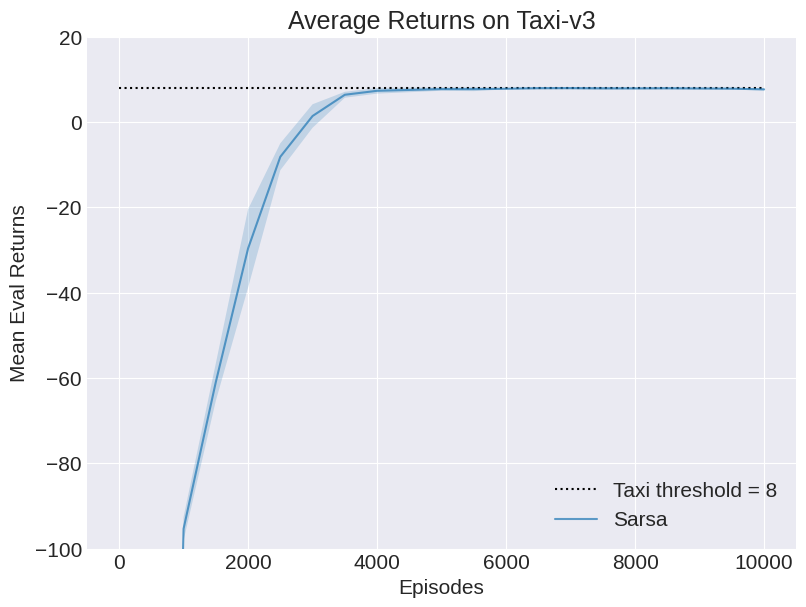

In [74]:
# plot returns
plt.figure(figsize=(8, 6))
axes = plt.gca()
plt.title(f"Average Returns on Taxi-v3")

# draw goal line
x_min = 0
x_max = CONFIG["total_eps"]
plt.hlines(y=8, xmin=x_min, xmax=x_max, colors='k', linestyles='dotted', label="Taxi threshold = 8")
axes.set_ylim([-100,20])

returns_total = eval_returns.mean(axis=0)
returns_std = eval_returns.std(axis=0)
plot_timesteps(CONFIG["eval_freq"], returns_total, returns_std, "Episodes", "Mean Eval Returns", "Sarsa")
plt.show()

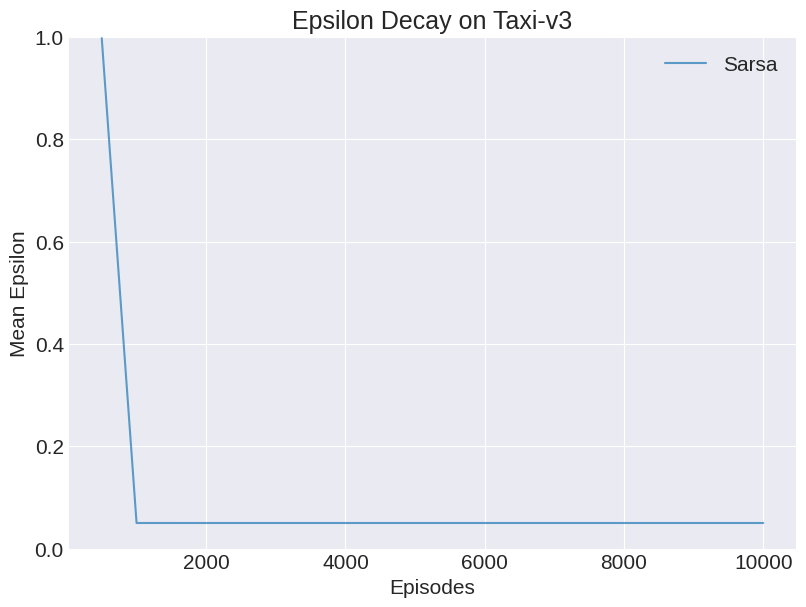

In [75]:
# plot epsilons
plt.figure(figsize=(8, 6))
axes = plt.gca()
plt.title(f"Epsilon Decay on Taxi-v3")
axes.set_ylim([0,1])

epsilons_mean = all_epsilons.mean(axis=0)
epsilons_std = all_epsilons.std(axis=0)
plot_timesteps(CONFIG["eval_freq"], epsilons_mean, epsilons_std, "Episodes", "Mean Epsilon", "Sarsa")
plt.show()

We can also check how the trained agent behaves in the environment by setting `render_mode=human` in the environment.

In [76]:
CONFIG['eval_episodes'] = 2
env = gym.make("Taxi-v3", render_mode="human")
# evaluating the first seed
evaluate(env, CONFIG, q_tables[0])
env.close()

You can check out the obtained `q_table` for debugging purposes, here we simply print them for the different seeds.

In [77]:
# visualise Q-tables
for i, q_table in enumerate(q_tables):
    print(f"Q-table for run {i + 1}")
    visualise_q_table(q_table, offset="\t")

Q-table for run 1
	Pos=0	Act=S	->	0
	Pos=0	Act=N	->	0
	Pos=0	Act=E	->	0
	Pos=0	Act=W	->	0
	Pos=0	Act=P	->	0
	Pos=0	Act=D	->	0
	Pos=1	Act=S	->	-2.7195326698105036
	Pos=1	Act=N	->	-2.011635804545622
	Pos=1	Act=E	->	-2.5180597482137457
	Pos=1	Act=W	->	-0.36270984878669593
	Pos=1	Act=P	->	5.1734991371516275
	Pos=1	Act=D	->	-8.826889952902924
	Pos=2	Act=S	->	0.8489654791479526
	Pos=2	Act=N	->	3.358307712553892
	Pos=2	Act=E	->	-0.9858064384189404
	Pos=2	Act=W	->	4.5848626856068435
	Pos=2	Act=P	->	12.331880599329054
	Pos=2	Act=D	->	-7.035397365509024
	Pos=3	Act=S	->	-1.1488068547788841
	Pos=3	Act=N	->	-1.2290205982870595
	Pos=3	Act=E	->	-2.0664482497800973
	Pos=3	Act=W	->	-1.4554190447468396
	Pos=3	Act=P	->	6.234647826188116
	Pos=3	Act=D	->	-6.81418532395637
	Pos=4	Act=S	->	-7.788235968104922
	Pos=4	Act=N	->	-9.93793096148282
	Pos=4	Act=E	->	-9.90598872776955
	Pos=4	Act=W	->	-10.011924811113722
	Pos=4	Act=P	->	-12.020726505206717
	Pos=4	Act=D	->	-14.159012571443007
	Pos=6	Act=S	->	-7.10210659

## Let's do some hyperparameter gridsearch over the learning rate
Here we will train SARSA agents for each random seed and visualise mean returns for various learning rates $\alpha$ to visualise the impact of this hyperparameter.

In [ ]:
LRs = [0.9, 0.7, 0.5, 0.3, 0.2, 0.1]

# dict mapping lr to (returns_mean, returns_std)
results_dict = {}

for lr in LRs:
    print(f"Start training with lr={lr}")
    config = CONFIG
    config["alpha"] = lr
    env = gym.make("Taxi-v3")

    num_returns = config["total_eps"] // config["eval_freq"]

    eval_returns = np.zeros((SEEDS, num_returns))
    all_epsilons = np.zeros((SEEDS, num_returns))
    q_tables = []
    for i in range(SEEDS):
        print(f"\tExecuting training for SARSA - run {i + 1}")
        env.reset(seed=i * 100)
        returns, _, epsilons, q_table = train(env, config, output=False) # output=True for evaluation info
        returns = np.array(returns)
        epsilons = np.array(epsilons)
        eval_returns[i, :] = returns
        all_epsilons[i, :] = epsilons
        q_tables.append(q_table)
    
    # plot returns for lr
    plt.figure(figsize=(8, 6))
    axes = plt.gca()
    plt.title(f"Average Returns on Taxi-v3 (LR={lr})")

    # draw goal line
    x_min = 0
    x_max = CONFIG["total_eps"]
    plt.hlines(y=8, xmin=x_min, xmax=x_max, colors='k', linestyles='dotted', label="Taxi threshold = 8")
    axes.set_ylim([-200,20])

    returns_total = eval_returns.mean(axis=0)
    returns_std = eval_returns.std(axis=0)
    results_dict[lr] = (returns_total, returns_std)
    plot_timesteps(CONFIG["eval_freq"], returns_total, returns_std, "Episodes", "Mean Eval Returns", "Sarsa")
    plt.show()

Start training with lr=0.9
	Executing training for SARSA - run 1
	Executing training for SARSA - run 2


## Visualise all learning rates
Now we are going to visualise the mean + std returns of all runs in one plot to directly compare and analyse the impact of the learning rate parameter.

We can see that with smaller learning rates, our training becomes increasingly robust, however it might take a couple more episodes until larger returns are reached.

In [ ]:
# plot returns of all learning rates next to each other
plt.figure(figsize=(12, 9))
axes = plt.gca()
plt.title(f"Average Returns on Taxi-v3 (Shading = half std)")

# draw goal line
x_min = 0
x_max = CONFIG["total_eps"]
plt.hlines(y=8, xmin=x_min, xmax=x_max, colors='k', linestyles='dotted', label="Taxi threshold = 8")
axes.set_ylim([-200,20])

for lr in LRs:
    returns_total, returns_std = results_dict[lr]
    plot_timesteps(CONFIG["eval_freq"], returns_total, returns_std/2, "Episodes", "Mean Eval Returns", f"Sarsa - lr={lr}")
plt.legend(loc="lower right", frameon=True, fancybox=True)
plt.show()